In [25]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

# --- Imports ---
from src.project_config import RAW_DIR, IMAGES_DIR, COLORS_MODELS, PROCESSED_DIR, PROTEIN_IDS_CSV, get_paths_protein, get_paths
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu
from pathlib import Path


In [11]:
protein_ids = pd.read_csv(PROTEIN_IDS_CSV) # all human proteins



aggregated_data = defaultdict(lambda: {
    'AM_Gene_Mean': 0.0, 
    'ESM_Gene_Mean': 0.0,
    'AM_Gene_Std': 0.0,
    'ESM_Gene_Std': 0.0,
    'Protein_Length': 0.0
})

error_counts = 0
for protein_id in tqdm(protein_ids['Protein_ID'], desc="Processing Proteins:"):
    try:
        protein = pd.read_csv(get_paths_protein(protein_id)["dssp_protein_path"])
    except FileNotFoundError:
        error_counts += 1
        continue

    am_mean = protein['AM_mean'].mean()
    esm_mean = protein['ESM_mean'].mean()

    # Overall std using pooled variance
    R = len(protein)  # number of residues
    N_total = 19 * R      # total number of data points (19 amino acids per residue)

    # AM pooled variance
    sum_sq_am = (18 * (protein['AM_std']**2) + 19 * (protein['AM_mean']**2)).sum()
    var_am_total = (sum_sq_am / N_total) - ( (19 * protein['AM_mean'].sum() / N_total) ** 2 )
    am_std_total = np.sqrt(var_am_total)

    # ESM pooled variance
    sum_sq_esm = ((18) * (protein['ESM_std']**2) + 19 * (protein['ESM_mean']**2)).sum()
    var_esm_total = (sum_sq_esm / N_total) - ( (19 * protein['ESM_mean'].sum() / N_total) ** 2 )
    esm_std_total = np.sqrt(var_esm_total)

    # Store
    aggregated_data[protein_id]['AM_Gene_Mean'] = round(am_mean, 4)
    aggregated_data[protein_id]['ESM_Gene_Mean'] = round(esm_mean, 4)
    aggregated_data[protein_id]['AM_Gene_Std'] = round(am_std_total, 4)
    aggregated_data[protein_id]['ESM_Gene_Std'] = round(esm_std_total, 4)
    aggregated_data[protein_id]['Protein_Length'] = protein['residue_position'].max()

# Convert to DataFrame and save
df_out = pd.DataFrame.from_dict(aggregated_data, orient='index').reset_index()
df_out.rename(columns={'index': 'entry'}, inplace=True)
df_out.to_csv(PROCESSED_DIR / "1.6.Gene_Level_Statistics.csv", index=False)

print(f"Processed {len(df_out)} proteins with {error_counts} errors.")


Processing Proteins::   0%|          | 0/20246 [00:00<?, ?it/s]

/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/2355528751.py:16: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  protein = pd.read_csv(get_paths_protein(protein_id)["dssp_protein_path"])


Processed 19927 proteins with 319 errors.


### 2. Do High Confidence Substrates Have Higher Gene Level Pathogenicity?

In [20]:
nout = pd.read_csv(PROCESSED_DIR / "Human_N_Out_Proteome.csv")

nout = nout.merge(df_out, left_on='entry', right_on='entry', how='left')


statistics = nout.groupby("pred_class").agg({"AM_Gene_Mean": "mean",
                                "ESM_Gene_Mean": "mean",
                                "Protein_Length": "mean"}).reset_index()





print(statistics)



#.to_csv(PROCESSED_DIR / "1.6.Gene_Level_Statistics_Nout.csv", index=False)




         pred_class  AM_Gene_Mean  ESM_Gene_Mean  Protein_Length
0  HC non-substrate      0.470739       0.402031      517.489362
1      HC substrate      0.489351       0.531697      940.752033
2  LC non-substrate      0.464289       0.447820      601.477509
3      LC substrate      0.457053       0.476569      667.258562


In [22]:
from scipy.stats import mannwhitneyu

# Select only the two classes of interest
groups = nout[nout['pred_class'].isin(["HC substrate", "HC non-substrate"])]

# Prepare results storage
results = []

# Columns to test
metrics = ["AM_Gene_Mean", "ESM_Gene_Mean"]

for metric in metrics:
    group1 = groups.loc[groups['pred_class'] == "HC substrate", metric].dropna()
    group2 = groups.loc[groups['pred_class'] == "HC non-substrate", metric].dropna()
    
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    results.append({
        "Metric": metric,
        "p_value": p_value
    })

# Convert to DataFrame for nice display
results_df = pd.DataFrame(results)
print(results_df)


          Metric       p_value
0   AM_Gene_Mean  7.960565e-02
1  ESM_Gene_Mean  1.232718e-14


/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/1374350216.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby('pred_class')[y_column].mean().reindex(category_order)


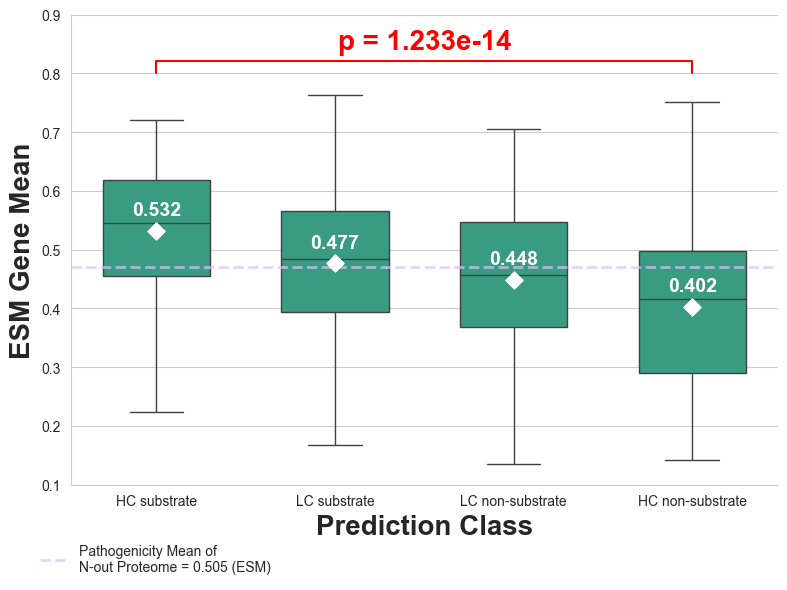

/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/1374350216.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby('pred_class')[y_column].mean().reindex(category_order)


ESM ESM_Gene_Mean Mann–Whitney p-value: 1.233e-14


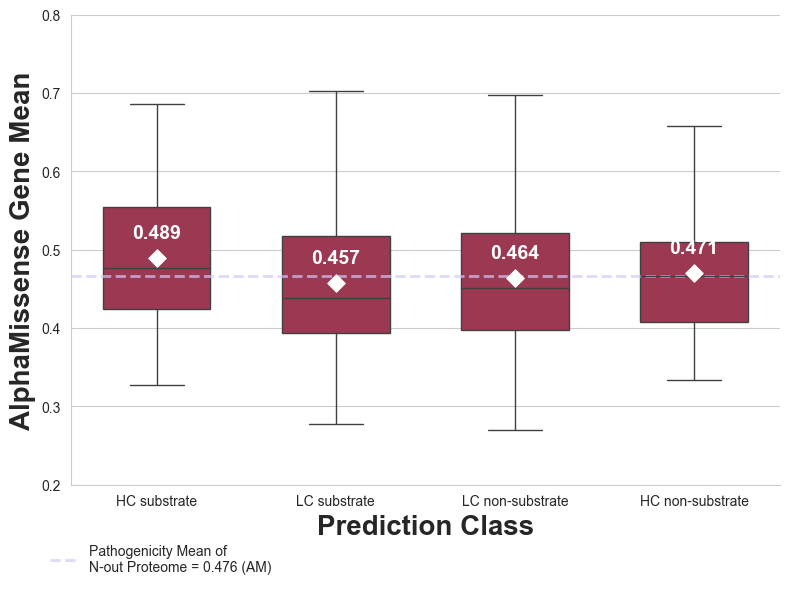

AlphaMissense AM_Gene_Mean Mann–Whitney p-value: 7.961e-02


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def plot_gene_mean_boxplot(data, y_column, model_name):
    base_color = COLORS_MODELS["ESM"] if model_name == "ESM" else COLORS_MODELS["AM"]
    
    category_order = ["HC substrate", "LC substrate", "LC non-substrate", "HC non-substrate"]
    data['pred_class'] = pd.Categorical(data['pred_class'], categories=category_order, ordered=True)
    
    plt.figure(figsize=(8,6))
    sns.set_style("whitegrid")
    
    ax = sns.boxplot(
        x="pred_class",
        y=y_column,
        data=data,
        color=base_color,
        showfliers=False,
        width=0.6
    )

    # Mean markers
    means = data.groupby('pred_class')[y_column].mean().reindex(category_order)
    sns.scatterplot(
        x=category_order,
        y=means.values,
        color='white',
        marker='D',
        s=80,
        zorder=5,
        ax=ax
    )

    # Annotate means above diamonds
    for i, mean_val in enumerate(means):
        ax.text(
            i, mean_val + 0.02,
            f"{mean_val:.3f}",
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold',
            color='white'
        )

    # Horizontal mean line across all data
    global_mean = data[y_column].mean()
    ax.axhline(
        y=global_mean,
        color='#d5c7f7',
        linestyle='--',
        linewidth=2,
        alpha=0.7,
        label=f'Pathogenicity Mean of\nN-out Proteome = {0.4765 if model_name == "AlphaMissense" else 0.505:.3f} ({"AM" if model_name == "AlphaMissense" else "ESM"})'
    )

    # Mann–Whitney U test
    g1 = data.loc[data['pred_class'] == "HC substrate", y_column].dropna()
    g2 = data.loc[data['pred_class'] == "HC non-substrate", y_column].dropna()
    _, p_value = mannwhitneyu(g1, g2, alternative='two-sided')
    
    if p_value < 0.05:
        x1, x2 = category_order.index('HC substrate'), category_order.index('HC non-substrate')
        y, h = max(g1.max(), g2.max()) + 0.05, 0.02
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='red')
        ax.text(
            (x1+x2)/2, y+h+0.01,
            f"p = {p_value:.3e}",
            ha='center', va='bottom',
            fontsize=20, fontweight='bold', color='red'
        )

    ax.set_xlabel("Prediction Class", fontsize=20, fontweight='bold')
    ax.set_ylabel(f"{model_name} Gene Mean", fontsize=20, fontweight='bold')
    ymin, ymax = ax.get_ylim()
    ax.set_yticks(np.arange(round(ymin, 1), round(ymax + 0.1, 1), 0.1))

    ax.legend(loc='upper right', bbox_to_anchor=(0.3, -0.10), frameon=False, fontsize=10)
    sns.despine()
    plt.tight_layout()


    save_dir = IMAGES_DIR / "1.6.Gene_Level_agg"
    save_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_dir / f"{model_name}_Gene_Mean_Boxplot.png", dpi=300)

    plt.show()

    print(f"{model_name} {y_column} Mann–Whitney p-value: {p_value:.3e}")


# Example usage:
plot_gene_mean_boxplot(nout, "ESM_Gene_Mean", "ESM")
plot_gene_mean_boxplot(nout, "AM_Gene_Mean", "AlphaMissense")


/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/2379213472.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/2379213472.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby('pred_class')[y_column].mean().reindex(category_order)
/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/2379213472.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

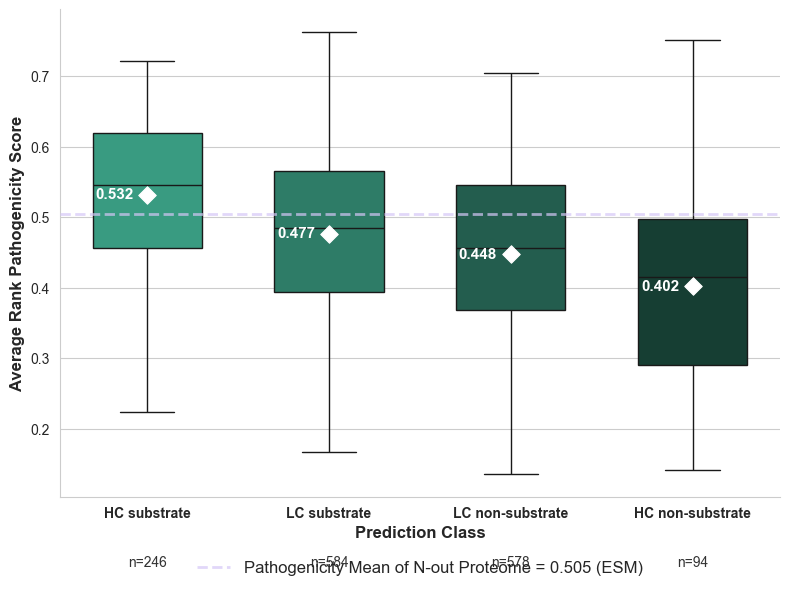

/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/2379213472.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


nan


/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/2379213472.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby('pred_class')[y_column].mean().reindex(category_order)
/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_34570/2379213472.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = data.groupby('pred_class')[y_column].count().reindex(category_order)


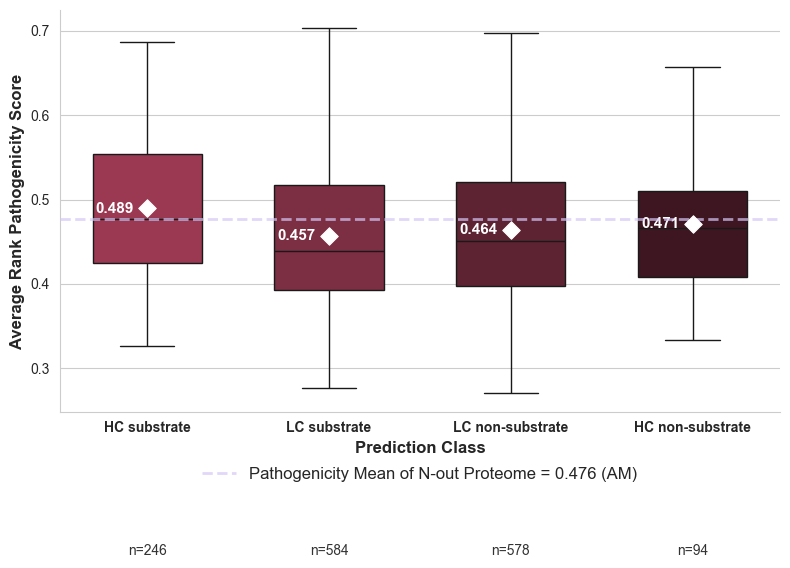

nan


In [53]:
# ESM version
plot_model_boxplot(
    data=nout, 
    y_column="ESM_Gene_Mean", 
    model="ESM", 
    save=False, 
    title=False
)

# AlphaMissense version
plot_model_boxplot(
    data=nout, 
    y_column="AM_Gene_Mean", 
    model="AlphaMissense", 
    save=False, 
    title=False
)
